In [1]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt
import gdal

gdal.UseExceptions()

%matplotlib inline

# Set plot fonts to a larger size
#plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings('ignore')

***
### Grand Mesa surface observations from three met stations, providing snow depth measurements througout the winter in 2017.

Load Grand Mesa West data

In [2]:
# Grand Mesa West data
filepath = r'met_data\MW-V5t_spestana.csv'
gm_west = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_west['datetime'] = pd.to_datetime(gm_west['TIMESTAMP (TS, )']) # timestamp string to pandas datetime
gm_west['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_west = gm_west.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_west_daily_median = gm_west
# Set the datetime column to this new data frame's index
gm_west_daily_median = gm_west_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_west_daily_median = gm_west_daily_median.resample('1D').median()

Load Grand Mesa Middle data

In [3]:
# Grand Mesa West data
filepath = r'met_data\MM-V3t_spestana.csv'
gm_middle = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_middle['datetime'] = pd.to_datetime(gm_middle['TIMESTAMP(TS, )']) # timestamp string to pandas datetime
gm_middle['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_middle = gm_middle.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_middle_daily_median = gm_middle
# Set the datetime column to this new data frame's index
gm_middle_daily_median = gm_middle_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_middle_daily_median = gm_middle_daily_median.resample('1D').median()

Load Grand Mesa (LSOS) data

In [4]:
# Grand Mesa East data
filepath = r'met_data\LSOS-V2t_spestana.csv'
gm_lsos = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_lsos['datetime'] = pd.to_datetime(gm_lsos['TIMESTAMP']) # timestamp string to pandas datetime
gm_lsos['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_lsos = gm_lsos.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_lsos_daily_median = gm_lsos
# Set the datetime column to this new data frame's index
gm_lsos_daily_median = gm_lsos_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_lsos_daily_median = gm_lsos_daily_median.resample('1D').median()

Plot daily median snow depths at all three sites:

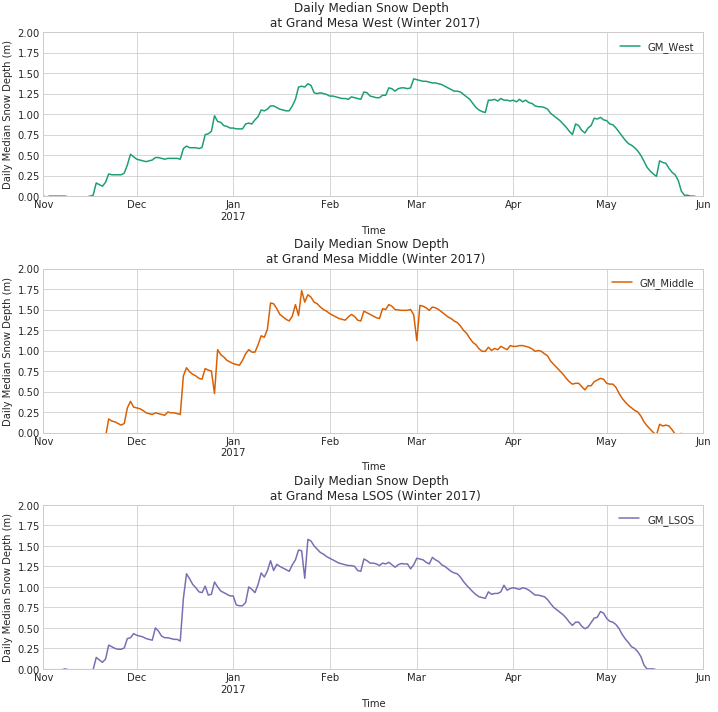

In [5]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')

# Plot daily median snow depths:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(3,1,figsize=(10,10))

    ax[0].set_title('Daily Median Snow Depth \n at Grand Mesa West (Winter 2017)');
    gm_west_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#1b9e77', ax=ax[0], 
                              label='GM_West')

    ax[1].set_title('Daily Median Snow Depth \n at Grand Mesa Middle (Winter 2017)');
    gm_middle_daily_median.plot(y='Snow Depth(m, Avg)', 
                                c='#d95f02', ax=ax[1], 
                                label='GM_Middle')

    ax[2].set_title('Daily Median Snow Depth \n at Grand Mesa LSOS (Winter 2017)');
    gm_lsos_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#7570b3', ax=ax[2], 
                              label='GM_LSOS')
    # format each subplot:
    for n in range(len(ax)):
        ax[n].set_ylim((0,2))
        ax[n].set_xlim((starttime,endtime))
        ax[n].set_ylabel('Daily Median Snow Depth (m)')
        ax[n].set_xlabel('Time')

    plt.tight_layout()
    plt.savefig('daily_median_snowdepth.png',dpi=300)

***